In [ ]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 39kB/s 
     |████████████████████████████████| 450kB 49.8MB/s 
     |████████████████████████████████| 3.8MB 15.6MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def sample_data():
  count = 10000
  rand = np.random.RandomState(0)
  a = 0.3 + 0.1 * rand.randn(count)
  b = 0.8 + 0.05 * rand.randn(count)
  mask = rand.rand(count) < 0.5
  samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
  return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [ ]:
data1 = sample_data()
train1, test1 = train_test_split(data1, test_size=0.2)
train1, val1 = train_test_split(train1, test_size=0.125)
print(train1.shape, val1.shape, test1.shape)

(7000,) (1000,) (2000,)


(array([  23.,   49.,  160.,  350.,  395.,  702.,  719.,  547.,  334.,
         130.,   78.,   19.,    6.,   52.,  189.,  896., 1384.,  805.,
         146.,   16.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ,
        53.8, 58.6, 63.4, 68.2, 73. , 77.8, 82.6, 87.4, 92.2, 97. ]),
 <a list of 20 Patch objects>)

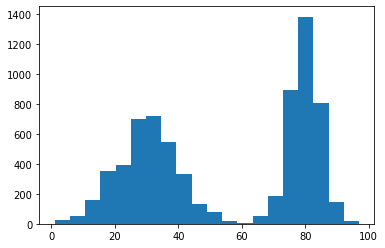

In [ ]:
plt.hist(train1,20)

In [ ]:
class Solver1(object):
  def __init__(self, input_range=100, batch_size=500, lr=5e-4, epochs=10000, log_every_epoch=30):
    self.input_range = input_range
    self.size = batch_size
    self.lr = lr
    self.epochs = epochs
    self.log = log_every_epoch
    self.theta = np.zeros(input_range)
    self.batch_size = batch_size

  def log2(self, x):
    return np.log(x)/np.log(2)
  
  def loss(self, x):
    th = self.theta[x]
    st = np.max(th)
    p = np.exp(th-st)/np.sum(np.exp(self.theta-st))
    loss = np.mean(-self.log2(p))
    return loss

  def update_theta(self, x):
    n = x.shape[0]
    gradient = np.ones(self.input_range)*1/n
    nos, counts = np.unique(x, return_counts=True)
    for no, count in zip(nos, counts):
      gradient[no] -= count/n
    self.theta -= self.lr*gradient  

  def train(self, x_trn, x_val):
    N = x_trn.shape[0]
    trn_loss =[]
    val_loss = []
    for epoch in range(self.epochs):
      np.random.shuffle(x_trn)
      trn_batch_loss =[]
      arr = np.array_split(x_trn , np.ceil(N/self.batch_size))
      for batch in arr:
        batch_loss = self.loss(batch)
        self.update_theta(batch)
        trn_batch_loss.append(batch_loss)
      if epoch % self.log == 0:
        trn_loss.append(np.mean(batch_loss))
        val_loss.append(self.loss(x_val))
        print('epoch: {} train_loss: {}  Validation_loss: {}'.format(epoch, trn_loss[-1], val_loss[-1]))
    return trn_loss, val_loss

best_lr=0
pr=0
for lr in np.linspace(1e-3,1e-7,20):
  if best_lr == 0:
    best_lr = lr
  solver = Solver1(lr=lr, epochs=5000, log_every_epoch=4999)
  print('lr: ',lr)
  loss_trn1, loss_val1 = solver.train(train1[:1000],val1)
  if loss_val1[-1]< pr:
      best_lr = lr
  pr = loss_val1[-1]
print(best_lr)

In [ ]:
solver = Solver1(lr=1e-3, epochs=4000)
loss_trn1, loss_val1 = solver.train(train1,val1)

epoch: 0 train_loss: 6.643632050273025  Validation_loss: 6.643633821350144
epoch: 30 train_loss: 6.636070131083828  Validation_loss: 6.636978838994134
epoch: 60 train_loss: 6.628559498256163  Validation_loss: 6.630355084011904
epoch: 90 train_loss: 6.620306947708925  Validation_loss: 6.623762738914353
epoch: 120 train_loss: 6.615699677486042  Validation_loss: 6.617201986771622
epoch: 150 train_loss: 6.606633512798064  Validation_loss: 6.610673011201877
epoch: 180 train_loss: 6.600713236289318  Validation_loss: 6.604175996359798
epoch: 210 train_loss: 6.596558780337324  Validation_loss: 6.597711126924796
epoch: 240 train_loss: 6.5842512951459025  Validation_loss: 6.591278588088931
epoch: 270 train_loss: 6.578581611338754  Validation_loss: 6.5848785655445585
epoch: 300 train_loss: 6.5693925511446505  Validation_loss: 6.578511245471667
epoch: 330 train_loss: 6.558943145340782  Validation_loss: 6.572176814524939
epoch: 360 train_loss: 6.551344429116021  Validation_loss: 6.5658754598205125


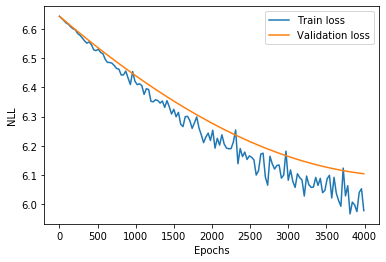

In [ ]:
plt.plot(range(0,solver.epochs,solver.log), loss_trn1, label='Train loss')
plt.plot(range(0,solver.epochs,solver.log), loss_val1, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()

In [ ]:
print('Test Loss: ',solver.loss(test1))

Test Loss:  6.009721862960977


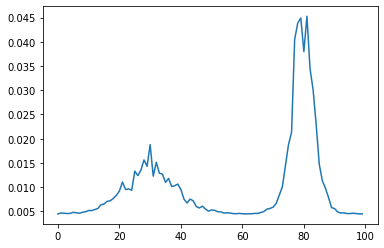

In [ ]:
prob = np.exp(solver.theta-np.max(solver.theta))/np.sum(np.exp(solver.theta-np.max(solver.theta)))
plt.plot(prob)

(array([ 22.,  14.,  26.,  18.,  34.,  43.,  42.,  55.,  49.,  37.,  24.,
         28.,  20.,  16.,  17.,  21.,  22.,  14.,  46., 171., 159.,  55.,
         25.,  18.,  24.]),
 array([  1.  ,   4.96,   8.92,  12.88,  16.84,  20.8 ,  24.76,  28.72,
         32.68,  36.64,  40.6 ,  44.56,  48.52,  52.48,  56.44,  60.4 ,
         64.36,  68.32,  72.28,  76.24,  80.2 ,  84.16,  88.12,  92.08,
         96.04, 100.  ]),
 <a list of 25 Patch objects>)

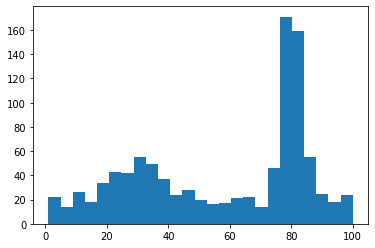

In [ ]:
samples = np.random.choice(range(1,101,1),1000,p=prob)
plt.hist(samples,25)